# Tutorial on Safe DeepRL by Daniel and Wei

This tutorial shows how you can train modern reinforcement learning algorithms with safety constraints given by a shield. The tutorial is diveded in 5 Exercises: 
- (1) Very ligthly delve into a continuous deep reinforcement learning policy optimization algorithm: Deep Deterministic Policy Gradient (DDPG). Understand and chose parameters for accordingly.
- (2) Make it work on a classical toy example "Pendulum-v0" and obtain a good policy.
- (3) Work with a harder environment "LunarLanding" and obtain a good policy.
- (4) Work with a, yet harder environment, "SafeLunarLanding" a harder version of "LunarLanding" modified in such a way that the ship explodes if certain forces are exerted in the engines. Testing the previous model and verifying extreme negative rewards throughout learning.
- (5) Designing a shield class, which shields the agent from exploding the ship, yielding reasonable rewards throughout learning.

### Exercise (1) Deep Deterministic Policy Gradient
Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.
It is, therefore, an actor-critic method, the actor is the policy and the critic the Q-function. Look at the get_actor() and get_critic() methods, fill the parameters for the layers, and more specifically for the outputs of the functions. Make sure they make sense.

Look for blocks #change here to alter and insert your solution.

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

from exploration import OUActionNoise
from rpm import Buffer, update_target

class DDPG:
    def __init__(self,
                 problem_name,
                 num_states,
                 num_actions,
                 lower_bound,
                 upper_bound,
                 total_episodes=100):

        self.problem_name = problem_name
        self.num_states = num_states
        self.num_actions = num_actions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        self.std_dev = 0.2
        self.ou_noise = OUActionNoise(mean=np.zeros(1),
                                      std_deviation=float(self.std_dev) *
                                      np.ones(1))

        self.actor_model = self.get_actor()
        self.critic_model = self.get_critic()

        self.target_actor = self.get_actor()
        self.target_critic = self.get_critic()

        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())

        # Learning rate for actor-critic models
        self.critic_lr = 0.002
        self.actor_lr = 0.001

        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_lr)

        self.total_episodes = total_episodes
        # Discount factor for future rewards
        self.gamma = 0.99
        # Used to update target networks
        self.tau = 0.005

        self.buffer = Buffer(50000,
                             64,
                             gamma=self.gamma,
                             num_states=self.num_states,
                             num_actions=self.num_actions)
    def get_actor(self):
        # Initialize weights between -3e-3 and 3-e3
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

# change here
        inputs = layers.Input(shape=(self.num_states, ))
        out = layers.Dense(1, activation="relu")(inputs)
        out = layers.Dense(1, activation="relu")(out)
        outputs = layers.Dense(1,
                               activation="tanh",
                               kernel_initializer=last_init)(out)
# change here

        # Our upper bound is 2.0 for Pendulum.
        outputs = outputs * self.upper_bound
        model = tf.keras.Model(inputs, outputs)
        return model


    def get_critic(self):
        # State as input
        state_input = layers.Input(shape=(self.num_states))
        state_out = layers.Dense(16, activation="relu")(state_input)
        state_out = layers.Dense(32, activation="relu")(state_out)

        # Action as input
        action_input = layers.Input(shape=(self.num_actions))
        action_out = layers.Dense(32, activation="relu")(action_input)

        # Both are passed through seperate layer before concatenating
        concat = layers.Concatenate()([state_out, action_out])

# change here
        out = layers.Dense(1, activation="relu")(concat)
        out = layers.Dense(1, activation="relu")(out)
        outputs = layers.Dense(1)(out)
# change here

        # Outputs single value for give state-action
        model = tf.keras.Model([state_input, action_input], outputs)

        return model

    def policy(self, state, noise_object):
        sampled_actions = tf.squeeze(self.actor_model(state))
        noise = noise_object()
        # Adding noise to action
        sampled_actions = sampled_actions.numpy() + noise

        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions, self.lower_bound,
                               self.upper_bound)

        return [np.squeeze(legal_action)]

    def save_parameters(self):

        # Save the weights
        actor_model.save_weights("pendulum_actor.h5")
        critic_model.save_weights("pendulum_critic.h5")

        target_actor.save_weights("pendulum_target_actor.h5")
        target_critic.save_weights("pendulum_target_critic.h5")

    def load_parameters(self):

        # Save the weights
        actor_model.load_parameters("pendulum_actor.h5")
        critic_model.load_parameters("pendulum_critic.h5")

        target_actor.load_parameters("pendulum_target_actor.h5")
        target_critic.load_parameters("pendulum_target_critic.h5")


### Exercise (2) Pendulum-v0

The classsic Pendulum-v0 environment is often used to benchmark deep reinforcement learning algorithms. The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright. For more information visit https://github.com/openai/gym/wiki/Pendulum-v0

In this Exercise, you will fine tune the paramters also changed above to verify the robustness of your model. An average reward higher of -200 is desirable. You do not need to change parameters in this exercise, make sure you at least understand what the method loop_env() is doing.

In [2]:
    problem = "Pendulum-v0"
    env = gym.make(problem)

    num_states = env.observation_space.shape[0]
    print("Size of State Space ->  {}".format(num_states))
    num_actions = env.action_space.shape[0]
    print("Size of Action Space ->  {}".format(num_actions))

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]

    print("Max Value of Action ->  {}".format(upper_bound))
    print("Min Value of Action ->  {}".format(lower_bound))


Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [6]:
 ddpg_agent = DDPG(problem_name=problem,
                      num_states=num_states,
                      num_actions=num_actions,
                      lower_bound=lower_bound,
                      upper_bound=upper_bound,
                      total_episodes=100)

In [7]:
    def loop_env():
        import matplotlib.pyplot as plt
        %matplotlib inline
        # from pyvirtualdisplay import Display
        # display = Display(visible=0, size=(1400, 900))
        # display.start()

        # is_ipython = 'inline' in plt.get_backend()
        # if is_ipython:
        #     from IPython import display

        # plt.ion()

        
        # To store reward history of each episode
        ep_reward_list = []
        # To store average reward history of last few episodes
        avg_reward_list = []
        # Takes about 4 min to train
        for ep in range(ddpg_agent.total_episodes):

            prev_state = env.reset()
            episodic_reward = 0
            render_episodes = 100
            # render = not (ep % render_episodes)
            render=False

            # if ddpg_agent.problem_name != 'Pendulum-v0':
            #     img = plt.imshow(env.render(mode='rgb_array'))
            while True:
                # Uncomment this to see the Actor in action
                # But not in a python notebook.
                # env.render()
                if render and ddpg_agent.problem_name != 'Pendulum-v0': 
                    img.set_data(env.render(mode='rgb_array')) # just update the data
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    action = env.action_space.sample()
                    env.step(action)

                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
                action = ddpg_agent.policy(tf_prev_state, ddpg_agent.ou_noise)
                # Recieve state and reward from environment.
                if ddpg_agent.num_actions>1:
                    action = action[0]
                else:
                    pass
                state, reward, done, info = env.step(action)


                ddpg_agent.buffer.record((prev_state, action, reward, state))
                episodic_reward += reward

                ddpg_agent.buffer.learn(ddpg_agent.target_actor,
                                        ddpg_agent.target_critic,
                                        ddpg_agent.actor_model,
                                        ddpg_agent.critic_model,
                                        ddpg_agent.actor_optimizer,
                                        ddpg_agent.critic_optimizer)

                update_target(ddpg_agent.target_actor.variables,
                            ddpg_agent.actor_model.variables, ddpg_agent.tau)
                update_target(ddpg_agent.target_critic.variables,
                            ddpg_agent.critic_model.variables, ddpg_agent.tau)

                # End this episode when `done` is True
                if done:
                    break

                prev_state = state

            ep_reward_list.append(episodic_reward)

            # Mean of last 40 episodes
            avg_reward = np.mean(ep_reward_list[-40:])
            print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
            avg_reward_list.append(avg_reward)

        # Plotting graph
        # Episodes versus Avg. Rewards
        plt.plot(avg_reward_list)
        plt.xlabel("Episode")
        plt.ylabel("Avg. Epsiodic Reward")
        plt.show()

In [8]:
loop_env()

Episode * 0 * Avg Reward is ==> -1071.3096891228606
Episode * 1 * Avg Reward is ==> -974.8462749876196
Episode * 2 * Avg Reward is ==> -1009.9158570632782
Episode * 3 * Avg Reward is ==> -1094.478580686191
Episode * 4 * Avg Reward is ==> -1213.0815172006392
Episode * 5 * Avg Reward is ==> -1207.1467537962296
Episode * 6 * Avg Reward is ==> -1241.4448990959213
Episode * 7 * Avg Reward is ==> -1194.9074478065324
Episode * 8 * Avg Reward is ==> -1220.0206540164043
Episode * 9 * Avg Reward is ==> -1287.8166571459017
Episode * 10 * Avg Reward is ==> -1287.9377813431963
Episode * 11 * Avg Reward is ==> -1271.2391557996582
Episode * 12 * Avg Reward is ==> -1252.7917261151279
Episode * 13 * Avg Reward is ==> -1265.982794060387
Episode * 14 * Avg Reward is ==> -1269.800340095587
Episode * 15 * Avg Reward is ==> -1286.1671997816939
Episode * 16 * Avg Reward is ==> -1281.1990274807533
Episode * 17 * Avg Reward is ==> -1263.317050215545
Episode * 18 * Avg Reward is ==> -1253.0975281546496
Episode 

KeyboardInterrupt: 

### Exercise (3) LunarLanding

The Lunar Landing exercise is far more challenging then Pendulum-0. In the LudarLander, the Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

For more information, visit https://github.com/openai/gym/wiki/Leaderboard#lunarlander-v2

In [6]:
    from lundar_landing import LunarLanderContinuous
    
    problem = "LunarLanderContinuous-v2"
    env = LunarLanderContinuous()

    num_states = env.observation_space.shape[0]
    print("Size of State Space ->  {}".format(num_states))
    num_actions = env.action_space.shape[0]
    print("Size of Action Space ->  {}".format(num_actions))

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]

    print("Max Value of Action ->  {}".format(upper_bound))
    print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [7]:
 ddpg_agent = DDPG(problem_name=problem,
                      num_states=num_states,
                      num_actions=num_actions,
                      lower_bound=lower_bound,
                      upper_bound=upper_bound,
                      total_episodes=100)

In reality, it takes thousands of episodes for DDPG to converge in this environment, just run for 100 episodes and observe the avg reward!

Episode * 0 * Avg Reward is ==> -135.84881063236875
Episode * 1 * Avg Reward is ==> -682.3434812681469
Episode * 2 * Avg Reward is ==> -701.1967451413014
Episode * 3 * Avg Reward is ==> -731.1467859768644
Episode * 4 * Avg Reward is ==> -832.3594245043629
Episode * 5 * Avg Reward is ==> -738.0088066544698
Episode * 6 * Avg Reward is ==> -676.423556631367
Episode * 7 * Avg Reward is ==> -630.0914681759814
Episode * 8 * Avg Reward is ==> -600.5605084491492
Episode * 9 * Avg Reward is ==> -586.5167115713288
Episode * 10 * Avg Reward is ==> -567.4638665091805
Episode * 11 * Avg Reward is ==> -547.0427808342287
Episode * 12 * Avg Reward is ==> -542.7455690876108
Episode * 13 * Avg Reward is ==> -533.0842503037352
Episode * 14 * Avg Reward is ==> -520.9283649365065
Episode * 15 * Avg Reward is ==> -503.65032804695784
Episode * 16 * Avg Reward is ==> -484.2889203265148
Episode * 17 * Avg Reward is ==> -471.48698356541496
Episode * 18 * Avg Reward is ==> -455.2025921076827
Episode * 19 * Avg R

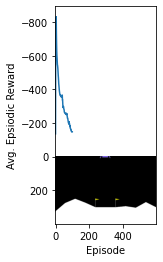

In [8]:
loop_env()

### Exercise (4) SafeLunarLanding

The SafeLunarLanding environment, is an altered version of LundarLander-v2 created for the purpose of this Tutorial. In this version, the main and lateral engines explode when put overpressure for more than 20 timesteps per episode. The spaceship is considered to be overpressured on its engines if one of the following situations is verified:

-(1) Main Engine over 0.7 capacity

-(2) Left Engine less than -0.7 capacity

-(3) Right Engine over 0.7 capacity

In [1]:
    from lundar_landing import LunarLanderContinuous
    from safe_lunar_env import SafeLunarEnv

    problem = "LunarLanderContinuous-v2"
    env = LunarLanderContinuous()
    env = SafeLunarEnv(env)

    num_states = env.observation_space.shape[0]
    print("Size of State Space ->  {}".format(num_states))
    num_actions = env.action_space.shape[0]
    print("Size of Action Space ->  {}".format(num_actions))

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]

    print("Max Value of Action ->  {}".format(upper_bound))
    print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [12]:
 ddpg_agent = DDPG(problem_name=problem,
                      num_states=num_states,
                      num_actions=num_actions,
                      lower_bound=lower_bound,
                      upper_bound=upper_bound,
                      total_episodes=100)

In reality, it takes thousands of episodes for DDPG to converge in this environment, just run for 100 episodes and observe the avg reward!

Episode * 0 * Avg Reward is ==> -49.148866015711775
Episode * 1 * Avg Reward is ==> -86.40185617682444
Episode * 2 * Avg Reward is ==> -100.87422612817572
Episode * 3 * Avg Reward is ==> -98.95731074796572
Episode * 4 * Avg Reward is ==> -101.5436323422533
Episode * 5 * Avg Reward is ==> -104.07432801382349
Episode * 6 * Avg Reward is ==> -131.07224277999427
Episode * 7 * Avg Reward is ==> -125.7874916570808
Episode * 8 * Avg Reward is ==> -158.21610386149004
Episode * 9 * Avg Reward is ==> -174.30499763840044
Episode * 10 * Avg Reward is ==> -273.92725471499546
Episode * 11 * Avg Reward is ==> -315.35829022904926
Episode * 12 * Avg Reward is ==> -340.77716846874296
Episode * 13 * Avg Reward is ==> -376.53657692299197
Episode * 14 * Avg Reward is ==> -381.0677591319303
Episode * 15 * Avg Reward is ==> -397.18164384392276
Episode * 16 * Avg Reward is ==> -394.2144404753348
Episode * 17 * Avg Reward is ==> -378.85141750668964
Episode * 18 * Avg Reward is ==> -375.9530585007737
Episode * 

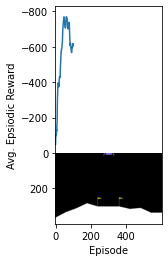

In [15]:
loop_env()

### Exercise (5) Shield for SafeLunarLanding
In this Exercise, you will implement the shield to save the spaceship from exploding! With Exercise 4 in mind, implement the needed action shield and parameters. Then test the agent and verify the yielding of much higher rewards through learning when compared with the version without the shield. Feel free change the paramters to verify its effects!

In [16]:
class Shield:
    def __init__(self,
                 thresholds_main_engine=1,
                 thresholds_left_engine=-1,
                 thresholds_right_engine=1):
        self.thresholds_main_engine = thresholds_main_engine
        self.thresholds_left_engine = thresholds_left_engine
        self.thresholds_right_engine = thresholds_right_engine

    def shield_action(self, action):

        #change here
        #change here
        return action

env = SafeLunarEnv(env, Shield())

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [17]:
 ddpg_agent = DDPG(problem_name=problem,
                      num_states=num_states,
                      num_actions=num_actions,
                      lower_bound=lower_bound,
                      upper_bound=upper_bound,
                      total_episodes=100)

Episode * 0 * Avg Reward is ==> -173.2371743554021
Episode * 1 * Avg Reward is ==> -398.8806484266995
Episode * 2 * Avg Reward is ==> -532.6264160071264
Episode * 3 * Avg Reward is ==> -657.0209617460499
Episode * 4 * Avg Reward is ==> -802.2495642775119
Episode * 5 * Avg Reward is ==> -836.656791483783
Episode * 6 * Avg Reward is ==> -961.785641295608
Episode * 7 * Avg Reward is ==> -948.2362633642592
Episode * 8 * Avg Reward is ==> -929.6517038737267
Episode * 9 * Avg Reward is ==> -989.826256614889
Episode * 10 * Avg Reward is ==> -993.5780668259439
Episode * 11 * Avg Reward is ==> -1010.0004958060081
Episode * 12 * Avg Reward is ==> -1014.5754873703778
Episode * 13 * Avg Reward is ==> -992.1024485678499
Episode * 14 * Avg Reward is ==> -978.8269774417307
Episode * 15 * Avg Reward is ==> -976.3974690467185
Episode * 16 * Avg Reward is ==> -965.9475750976387
Episode * 17 * Avg Reward is ==> -991.5877751780403
Episode * 18 * Avg Reward is ==> -989.0625065031471
Episode * 19 * Avg Rewa

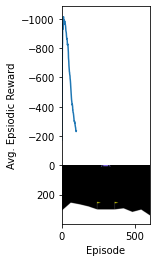

In [18]:
loop_env()